In [31]:
import os
import cv2
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision import transforms as tt
from torchvision.transforms import ToTensor, Normalize, Compose
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BCELoss
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm

In [2]:
data_dir = 'CNRPark-Patches-150x150'
train_dir = data_dir + '/A'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/A')
print(classes)

['A', 'B', 'test']
['busy', 'free']


In [3]:
dataset = ImageFolder(data_dir + '/A', transform=ToTensor())
image, label = dataset[0]
print(image.shape, label)

torch.Size([3, 150, 150]) 0


In [4]:
print(dataset.classes)

['busy', 'free']


In [7]:
train_ds = ImageFolder(data_dir + '/A', transform=ToTensor()) #train_fried
val_ds = ImageFolder(data_dir + '/B', transform=ToTensor()) #val_fried

In [8]:
train_size = 5500
val_size = len(dataset) - train_size

len(train_ds), len(val_ds)
print(f'Validation split: {val_size / len(dataset)}, Training split: {train_size / len(dataset)}') #show percentage split

Validation split: 0.10873440285204991, Training split: 0.8912655971479501


In [9]:
train_dl = DataLoader(train_ds, 128, shuffle=True, num_workers=1, pin_memory=True)
val_dl = DataLoader(val_ds, 128, shuffle=True, num_workers=1, pin_memory=True)

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        images, labels = images.to(device), labels.to(device)
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'train_loss': loss, 'train_acc': acc}
    
    def validation_step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, train_acc: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['train_acc'], result['val_acc']))

In [18]:
class ParkincCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.8),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.4), 
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )
        
    def forward(self, input_batch):
        return self.network(input_batch)

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in tqdm(val_loader)]
    return model.validation_epoch_end(outputs)

In [21]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        train_acc = []
        for batch in train_loader:
            info = model.training_step(batch)
            train_losses.append(info['train_loss'])
            train_acc.append(info['train_acc'])
            info['train_loss'].backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_acc).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [22]:
model = ParkincCnnModel()
model.to(device)

ParkincCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.8, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Dropout(p=0.2, inplace=False)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): ReLU()
    (12): Dropout(p=0.4, inplace=False)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): Conv2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (17): ReLU()
    (18): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_m

In [23]:
epochs = 10
lr = 1e-5
opt_func = torch.optim.Adam

history = fit(epochs, lr, model, train_dl, val_dl, opt_func)

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.48it/s]


Epoch [0], train_loss: 0.6887, val_loss: 0.6803, train_acc: 0.5866, val_acc: 0.7473


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.50it/s]


Epoch [1], train_loss: 0.6828, val_loss: 0.6720, train_acc: 0.5851, val_acc: 0.7446


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.48it/s]


Epoch [2], train_loss: 0.6766, val_loss: 0.6649, train_acc: 0.5869, val_acc: 0.7459


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.51it/s]


Epoch [3], train_loss: 0.6417, val_loss: 0.6466, train_acc: 0.6005, val_acc: 0.7459


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.48it/s]


Epoch [4], train_loss: 0.4360, val_loss: 0.5569, train_acc: 0.8506, val_acc: 0.8171


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.48it/s]


Epoch [5], train_loss: 0.2609, val_loss: 0.5135, train_acc: 0.8977, val_acc: 0.8549


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.48it/s]


Epoch [6], train_loss: 0.2114, val_loss: 0.4656, train_acc: 0.9174, val_acc: 0.8499


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.49it/s]


Epoch [7], train_loss: 0.1928, val_loss: 0.4711, train_acc: 0.9300, val_acc: 0.8559


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.48it/s]


Epoch [8], train_loss: 0.1783, val_loss: 0.4904, train_acc: 0.9321, val_acc: 0.8397


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:11<00:00,  4.50it/s]

Epoch [9], train_loss: 0.1590, val_loss: 0.4495, train_acc: 0.9408, val_acc: 0.8554


In [25]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

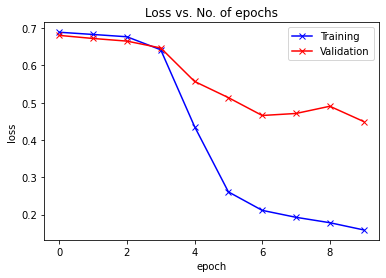

In [26]:
plot_losses(history)

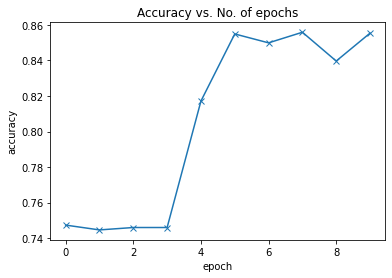

In [27]:
plot_accuracies(history)

In [28]:
def prediction(image, model):
    input_batch = image.unsqueeze(0).to(device) #Convert to a batch of 1
    output_batch = model(input_batch).to(device) #Get predictions from model
    _, preds  = torch.max(output_batch, dim=1) #Pick index with highest probability
    return dataset.classes[preds[0].item()] #Retrieve the class label

In [46]:
i = 1
width = 150
height = 150
dim = (width, height)
image = cv2.imread("C:\\Users\\stefa\\Desktop\\Demo image cropped\\the_image_cropped.jpg")
#image_cropped = cv2.resize(originalImage, (1920,1080), interpolation=cv2.INTER_AREA)
f = open("C:\\Users\\stefa\\Desktop\\Demo image cropped\\Crop coordinates manually.txt",'r')
Lines = f.readlines()
for line in Lines:
    coordinates = line.split(",")
    coordinates[3] = int(coordinates[3])
    print(coordinates)
    cropped = image[int(coordinates[0]):int(coordinates[1]), int(coordinates[2]):int(coordinates[3])]
    # resize image to 150x150
    resized = cv2.resize(cropped, dim, interpolation=cv2.INTER_AREA)
    cv2.imwrite(f"C:\\Users\\stefa\\CNRPark-Patches-150x150\\test\\test\\{i}.jpg", resized)
    i = i + 1

['507', '590', '33', 198]
['510', '565', '212', 360]
['494', '559', '378', 520]
['483', '552', '525', 663]
['480', '543', '656', 780]
['471', '537', '787', 905]
['464', '530', '908', 1022]
['458', '528', '1032', 1116]
['453', '512', '1132', 1224]
['457', '505', '1235', 1303]
['437', '507', '1309', 1395]
['441', '489', '1395', 1457]
['428', '488', '1462', 1525]
['361', '386', '1238', 1301]
['344', '380', '1294', 1381]
['583', '724', '1223', 1428]
['656', '727', '641', 883]
['632', '726', '965', 1251]
['574', '670', '1370', 1526]


In [47]:
testset = ImageFolder(data_dir + '/test', transform=ToTensor())

Label: ['busy', 'free'] Predicted: busy


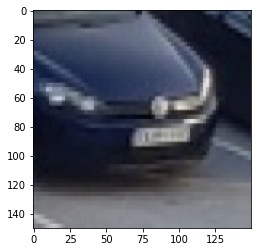

In [54]:
image, label = testset[1]
plt.imshow(image.permute(1, 2, 0))
print(f'Label: {dataset.classes} Predicted: {prediction(image, model)}')

In [55]:
test_dl = DataLoader(testset, 128, num_workers=1, pin_memory=True)
result = evaluate(model, test_dl)
result

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


{'val_loss': 0.4282774329185486, 'val_acc': 0.7599999904632568}

In [53]:
torch.save(model.state_dict(), 'parkinc-cnn.pth')

In [ ]:
#model = ParkincCnnModel()
#model.to(device)
#model.load_state_dict(torch.load('parkinc-cnn.pth'))

In [ ]:
#test_dl = DataLoader(testset, 128, num_workers=1, pin_memory=True)
#testset = ImageFolder(data_dir + '/test', transform=ToTensor())
#result = evaluate(model, test_dl)
#result